# DATA ANALYSIS OF LA LIGA
The data used for this initial data analysis contains the information of matches ranging from season 1928/1929 to 2021/2022.

The different studies will be separated by title and brief description and the code for that specific problem.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os

In [3]:
db_path = os.path.join(os.getcwd(), 'laliga.sqlite')
laliga_con = sqlite3.connect(str(db_path))
cursor = laliga_con.cursor()

### 1.  Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.

In [4]:
cursor.execute('SELECT * FROM Matches')
data = cursor.fetchall()

columns = cursor.execute('PRAGMA table_info(Matches)').fetchall()
columns = [col[1] for col in columns]

df = pd.DataFrame(data, columns=columns)
df = df[df['score'].notna()]

In [5]:
df[['goals_home', 'goals_away']] = df['score'].str.split(':', expand=True).astype(int)

In [6]:
results = [
    (df['goals_home'] > df['goals_away']),
    (df['goals_home'] == df['goals_away']),
    (df['goals_home'] < df['goals_away'])
]

df['result'] = np.select(results, ['1', 'X', '2'])

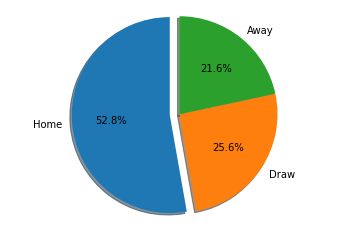

In [7]:
wins = df['result'].value_counts()

labels = ['Home', 'Draw', 'Away']
sizes = [wins['1'], wins['X'], wins['2']]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### 2. What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division. What have been the biggest wins? Of course, when we say biggest we mean those with the highest goal difference. Show the top ten of them in a table.


In [8]:
df_1div = df.loc[df['division'] == 1].copy()
df_1div['goal_diff'] = abs(df['goals_home'] - df['goals_away'])


In [9]:
unique_teams = df_1div['home_team'].unique()

goals_dict = { team : {'scored':0, 'conceded':0} for team in unique_teams}

for team in unique_teams:
    games = 0

    df_aux = df_1div.loc[df['home_team'] == team]
    goals_dict[team]['scored'] += df_aux['goals_home'].sum()
    goals_dict[team]['conceded'] += df_aux['goals_away'].sum()
    games += df_aux.size

    df_aux = df_1div.loc[df['away_team'] == team]
    goals_dict[team]['conceded'] += df_aux['goals_home'].sum()
    goals_dict[team]['scored'] += df_aux['goals_away'].sum()
    games += df_aux.size

    goals_dict[team]['avg_scored'] = float(goals_dict[team]['scored'] / games)
    goals_dict[team]['avg_conceded'] = float(goals_dict[team]['conceded'] / games)

top_scorers = sorted(goals_dict.items(), key=lambda k_v: k_v[1]['scored'], reverse=True)[:10]
top_scorers = [[team[0], team[1]['scored']] for team in top_scorers]
top_conceders = sorted(goals_dict.items(), key=lambda k_v: k_v[1]['conceded'], reverse=True)[:10]
top_conceders = [[team[0], team[1]['conceded']] for team in top_conceders]

top_avg_scorers = sorted(goals_dict.items(), key=lambda k_v: k_v[1]['avg_scored'], reverse=True)[:10]
top_avg_scorers = [[team[0], team[1]['avg_scored']] for team in top_avg_scorers]
top_avg_conceders = sorted(goals_dict.items(), key=lambda k_v: k_v[1]['avg_conceded'], reverse=True)[:10]
top_avg_conceders = [[team[0], team[1]['avg_conceded']] for team in top_avg_conceders]

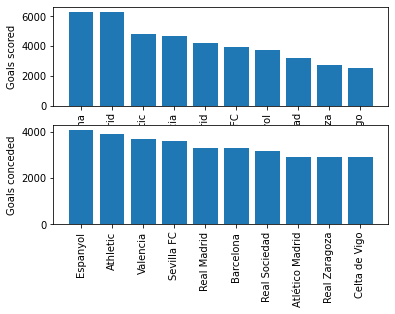

In [10]:
x = range(10)

plt.subplot(2,1,1)
x_labels1 = [team[0] for team in top_scorers]
x_values1 = [team[1] for team in top_scorers]
scored = plt.bar(x, x_values1)
plt.ylabel('Goals scored')
plt.xticks(x, x_labels1, rotation='vertical')

plt.subplot(2,1,2)
x_labels2 = [team[0] for team in top_conceders]
x_values2 = [team[1] for team in top_conceders]
conceded = plt.bar(x, x_values2)
plt.ylabel('Goals conceded')
plt.xticks(x, x_labels2, rotation='vertical')

plt.show()

### #3. There has been a lot of discussion about how La Liga’s television right shave changed game schedules in the last years. Make a bar plot chart showing the number of matches played each weekday, and make also a histogram of match time. Compare this two graphics between seasons 2000-2001 and 2020-2021.

In [11]:
df_diego = df.copy()
df_diego['date'] = pd.to_datetime(df_diego['date'])
df_diego['day'] = df_diego['date'].dt.day_name()
df_2000 = df_diego.loc[(df_diego['season'] == "2000-2001")]
df_2000 = df_2000.dropna()
df_2021 = df_diego.loc[(df_diego['season'] == "2020-2021")]
df_2021 = df_2021.dropna()

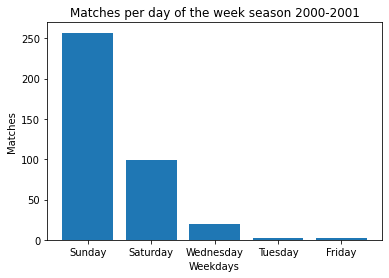

In [12]:
y = df_2000['day'].value_counts()
x = ["Sunday", "Saturday", "Wednesday", "Tuesday", "Friday"]
plt.bar(x, y)
plt.title('Matches per day of the week season 2000-2001')
plt.xlabel('Weekdays')
plt.ylabel('Matches')
plt.show()


In [13]:
df_2000['time'] = pd.to_datetime(df_2000['time']).dt.strftime('%H%M%S')
df_2000['time'] = df_2000['time'].astype(int)

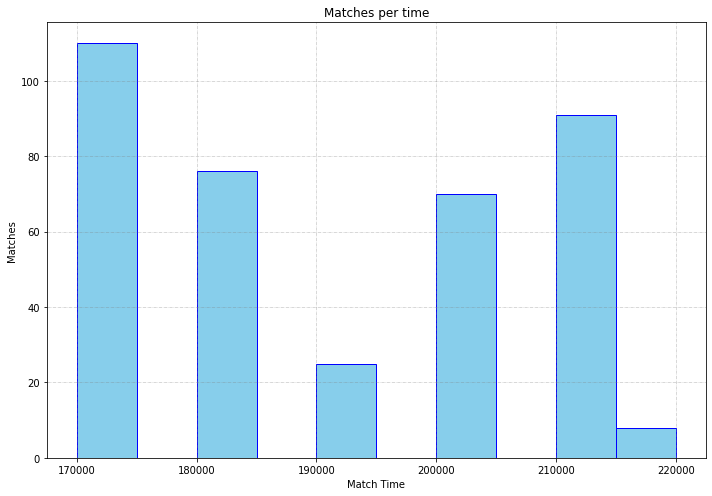

In [14]:
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
axs.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

axs.hist(df_2000['time'], color = "skyblue", ec = "blue", lw = 1)
 
# Adding extra features   
plt.xlabel("Match Time")
plt.ylabel("Matches")
plt.title('Matches per time')
 
# Show plot
plt.show()

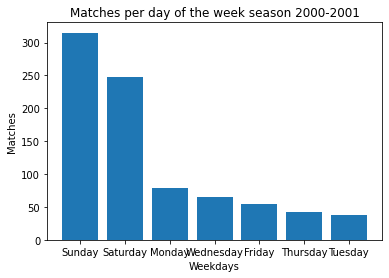

In [15]:
y = df_2021['day'].value_counts()
x = ["Sunday", "Saturday", "Monday", "Wednesday", "Friday", "Thursday", "Tuesday"]
plt.bar(x, y)
plt.title('Matches per day of the week season 2000-2001')
plt.xlabel('Weekdays')
plt.ylabel('Matches')
plt.show()

In [16]:
df_2021['time'] = pd.to_datetime(df_2021['time']).dt.strftime('%H%M%S')
df_2021['time'] = df_2021['time'].astype(int)

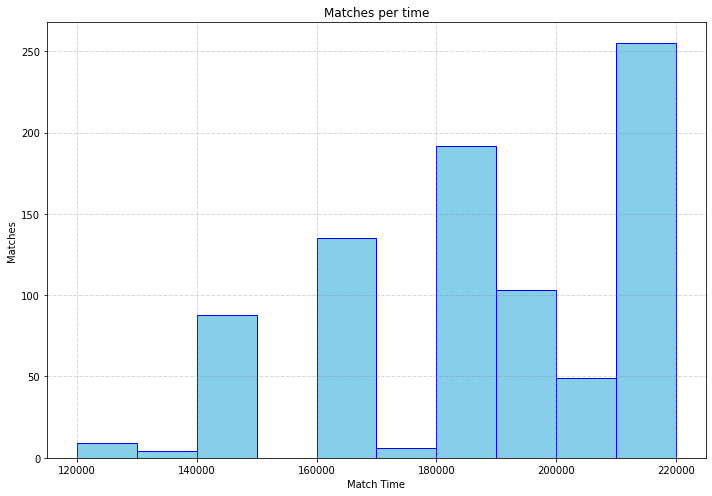

In [17]:
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
axs.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

axs.hist(df_2021['time'], color = "skyblue", ec = "blue", lw = 1)
 
# Adding extra features   
plt.xlabel("Match Time")
plt.ylabel("Matches")
plt.title('Matches per time')
 
# Show plot
plt.show()

### 4. Build a cross results table for season 2020-2021 (1st division). Figure 1 is an example taken from Wikipedia. Try to make it the most similar to this one: use team abbreviations as column names and paint the background of each cell according to result (green in case local team wins and red in case visitor team wins). Also, could you model the intensity of this background color with the goal difference from the match?Write a function that, given the season and division, plots the cross results table. Function prototype should be like plot_cross_results_table(season, division) and return the plot object.

In [18]:
#import seaborn as sns
def plot_cross_resuts_table(division, season):
    division_data = df.loc[df['division'] == division].copy()
    season_data = division_data.loc[division_data['season'] == season].copy()
    laliga_crosstable = pd.crosstab(season_data['home_team'], season_data['away_team'], values=season_data['score'], aggfunc=','.join)
    #sns.heatmap(laliga_crosstable, cmap='rocket_r', annot=True, fmt='g')
    return laliga_crosstable

cross_table = plot_cross_resuts_table(1, '2020-2021')
cross_table

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,NaN,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,NaN,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,NaN,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,NaN,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,NaN,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,NaN,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,NaN,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,NaN,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,NaN,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


## 5. As you surely know, there has always been a historical rivalry between Barcelona and Real Madrid. But which of them has won the most games in direct confrontations? Which of them has scored the most goals in these games? Show both things in two pie charts, side by side. Remember to consider ties in the first one. Write a function that, given two team names, plots the two graphs described above. Function prototype should be like plot_direct_confrontations_stats(team1, team2) and return the plot object. Use it with some other classical rivals like Betis and Sevilla.

La función funciona bien y podría dejarse tal y como está. Pero podríamos intentar ver cómo hacer lo mismo con menos líneas de código.

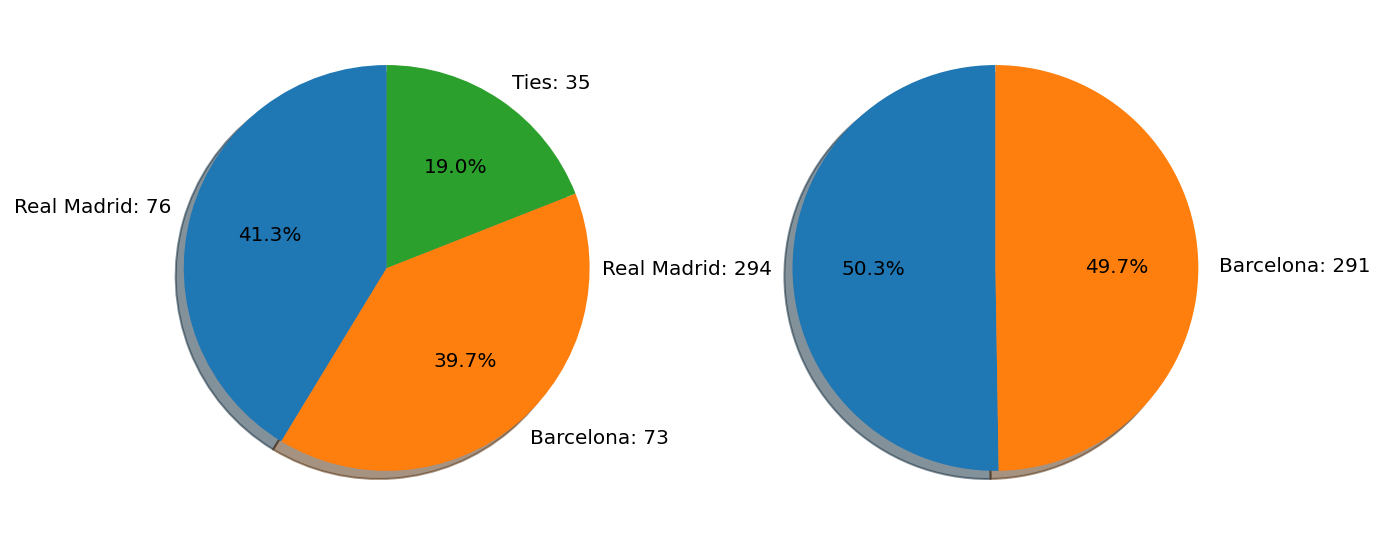

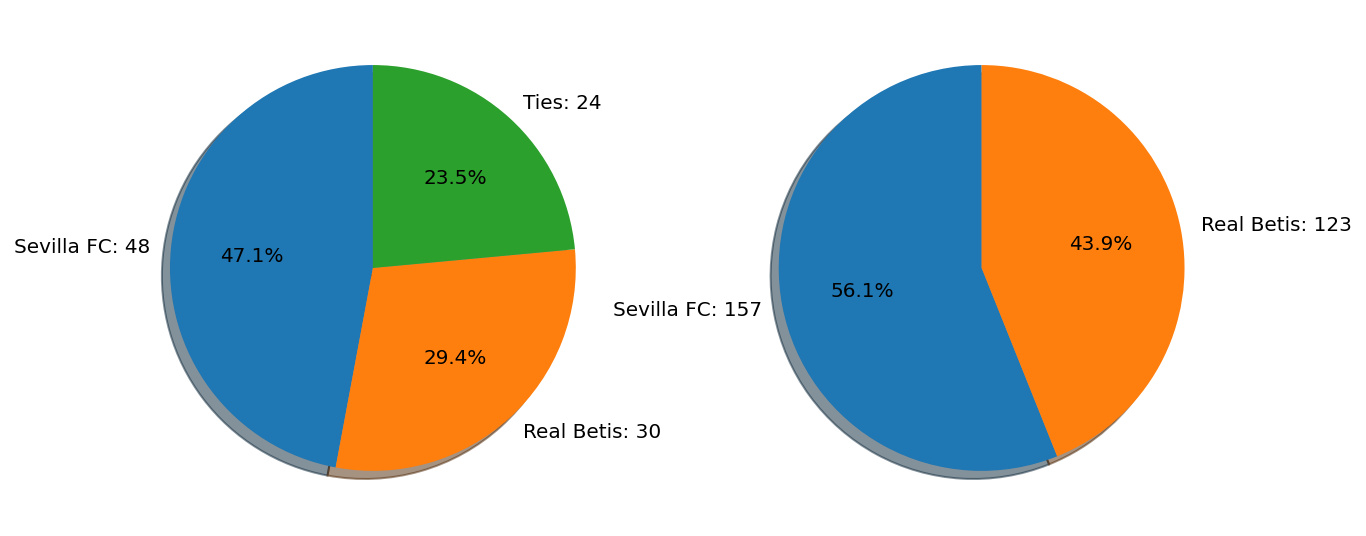

0

In [50]:
def plot_direct_confrontations_stats(team1, team2):
    team1_home = df.loc[df['home_team'] == team1].copy()
    team1_home = team1_home.loc[team1_home['away_team'] == team2].copy()

    team2_home = df.loc[df['home_team'] == team2].copy()
    team2_home = team2_home.loc[team2_home['away_team'] == team1].copy()

    home_goals_1 = team1_home['goals_home'].sum() # Goles team1 casa
    away_goals_1 = team2_home['goals_away'].sum() # Goles team1 fuera
    total_goals_team1 = home_goals_1 + away_goals_1

    home_goals_2 = team2_home['goals_home'].sum() # Goles team2 casa
    away_goals_2 = team1_home['goals_away'].sum() # Goles team2 fuera
    total_goals_team2 = home_goals_2 + away_goals_2

    total_wins_team1 = 0
    total_wins_team2 = 0
    total_ties = 0

    for result in team1_home['result']:
        if result == '1': total_wins_team1 += 1
        elif result == '2': total_wins_team2 += 1
        else: total_ties += 1

    for result in team2_home['result']:
        if result == '1': total_wins_team2 += 1
        elif result == '2': total_wins_team1 += 1
        else: total_ties += 1
    
    y_results = np.array([total_wins_team1, total_wins_team2, total_ties])
    y_goals   = np.array([total_goals_team1, total_goals_team2])


    label1 = team1+": "+str(total_wins_team1)
    label2 = team2+": "+str(total_wins_team2)
    label3 = "Ties: "+str(total_ties)
    label4 = team1+": "+str(total_goals_team1)
    label5 = team2+": "+str(total_goals_team2)

    mylabels_results = [label1, label2, label3]
    mylabels_goals = [label4, label5]

    fig = plt.figure(figsize=(10,7),dpi=144)

    ax1 = plt.subplot(121) #figsize =(10, 7)
    ax1.pie(y_results, labels = mylabels_results, autopct = '%1.1f%%',
            shadow = True, startangle = 90)

    ax2 = plt.subplot(122)
    ax2.pie(y_goals, labels = mylabels_goals, autopct = '%1.1f%%',
    shadow = True, startangle = 90)

    plt.show()
    return 0

plot_direct_confrontations_stats("Real Madrid", "Barcelona")
plot_direct_confrontations_stats("Sevilla FC", "Real Betis")
    

In [30]:
#Bernabeu
team1_home = df.loc[df['away_team'] == "Barcelona"].copy()
team1_home = team1_home.loc[team1_home['home_team'] == "Real Madrid"].copy()
home_goals_1 = team1_home['goals_home'].sum() #Madrid en casa
away_goals_1 = team1_home['goals_away'].sum() #Barça fuera
    

#Camp Nou 
team2_home = df.loc[df['home_team'] == "Barcelona"].copy()
team2_home = team2_home.loc[team2_home['away_team'] == "Real Madrid"].copy()
home_goals_2 = team2_home['goals_home'].sum() #Barça en casa
away_goals_2 = team2_home['goals_away'].sum() #Madrid fuera



total_wins_team1 = 0
total_wins_team2 = 0
total_draws = 0

for result in team1_home['result']:
    if result == '1': total_wins_team1 += 1
    elif result == '2': total_wins_team2 += 1
    else: total_draws += 1

for result in team2_home['result']:
    if result == '1': total_wins_team2 += 1
    elif result == '2': total_wins_team1 += 1
    else: total_draws += 1

print(total_wins_team1)
print(total_wins_team2)
print(total_draws)

team1_total_goals = home_goals_1 + away_goals_2
team2_total_goals = home_goals_2 + away_goals_1
total_confrontations = len(team1_home) + len(team2_home)
print(total_confrontations)

76
73
35
184


## 6. Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the longest undefeated streaks in a horizontal bar plot, indicating in each bar the team name and the dates it held that streak, for instance, Real Sociedad 22/04/1979 - 04/05/1980.